In [104]:
import numpy as np
import pandas as pd
import pickle
#import seaborn as sns
import matplotlib.pyplot as plt

In [105]:
#Retrieve pickle object
fileObj = open('data_algos.pkl', 'rb')
all_generations = pickle.load(fileObj)
fileObj.close()

In [106]:
#creating one DataFrame for each selection method
generations_df = pd.DataFrame(all_generations)
new_generations_df=generations_df[generations_df['mutation']==0]
#checking the results
new_generations_df.sample(5)

,radius,generation,fitness,selection_type,pop_size,mutation
147696,24.470588,335,0.000266,Random Selection,75,0.0
478236,1.882353,270,0.018471,Ranked Selection,95,0.0
566220,2.117647,67,0.017696,Wheel Selection,55,0.0
743918,1.882353,435,0.018471,Wheel Selection,95,0.0
349687,1.882353,149,0.018471,Ranked Selection,65,0.0


In [107]:
#Sample Statistics
new_generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])


radius                                            \
                             count       mean       std       min        50%   
selection_type   generation                                                    
Random Selection 0           500.0  16.132941  8.469286  0.117647  16.352941   
                 1           500.0  15.666588  8.339888  0.117647  15.294118   
                 2           500.0  15.841176  8.113403  0.117647  16.176471   
                 3           500.0  15.260941  8.018637  0.117647  15.529412   
                 4           500.0  14.457176  8.113976  0.470588  13.941176   
...                            ...        ...       ...       ...        ...   
Wheel Selection  495         500.0   1.751765  0.191993  1.411765   1.764706   
                 496         500.0   1.751765  0.191993  1.411765   1.764706   
                 497         500.0   1.751765  0.191993  1.411765   1.764706   
                 498         500.0   1.751765  0.191993  1.411765   1.764706   
                 499         500.0   1.751765  0.191993  1.411765   1.764706   

                                       fitness                                \
                                   max   count      mean       std       min   
selection_type   generation                                                    
Random Selection 0           30.000000   500.0  0.002332  0.004090  0.000177   
                 1           30.000000   500.0  0.002359  0.004035  0.000177   
                 2           30.000000   500.0  0.002170  0.003701  0.000177   
                 3           30.000000   500.0  0.002435  0.004060  0.000177   
                 4           29.882353   500.0  0.002826  0.004426  0.000178   
...                                ...     ...       ...       ...       ...   
Wheel Selection  495          2.470588   500.0  0.018480  0.000471  0.015965   
                 496          2.470588   500.0  0.018480  0.000471  0.015965   
                 497          2.470588   500.0  0.018480  0.000471  0.015965   
                 498          2.470588   500.0  0.018480  0.000471  0.015965   
                 499          2.470588   500.0  0.018480  0.000471  0.015965   

                             ...   pop_size                  mutation       \
                             ...        std  min   50%   max    count mean   
selection_type   generation  ...                                             
Random Selection 0           ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 1           ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 2           ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 3           ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 4           ...  23.534182  5.0  75.0  95.0    500.0  0.0   
...                          ...        ...  ...   ...   ...      ...  ...   
Wheel Selection  495         ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 496         ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 497         ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 498         ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 499         ...  23.534182  5.0  75.0  95.0    500.0  0.0   

                                                 
                             std  min  50%  max  
selection_type   generation                      
Random Selection 0           0.0  0.0  0.0  0.0  
                 1           0.0  0.0  0.0  0.0  
                 2           0.0  0.0  0.0  0.0  
                 3           0.0  0.0  0.0  0.0  
                 4           0.0  0.0  0.0  0.0  
...                          ...  ...  ...  ...  
Wheel Selection  495         0.0  0.0  0.0  0.0  
                 496         0.0  0.0  0.0  0.0  
                 497         0.0  0.0  0.0  0.0  
                 498         0.0  0.0  0.0  0.0  
                 499         0.0  0.0  0.0 

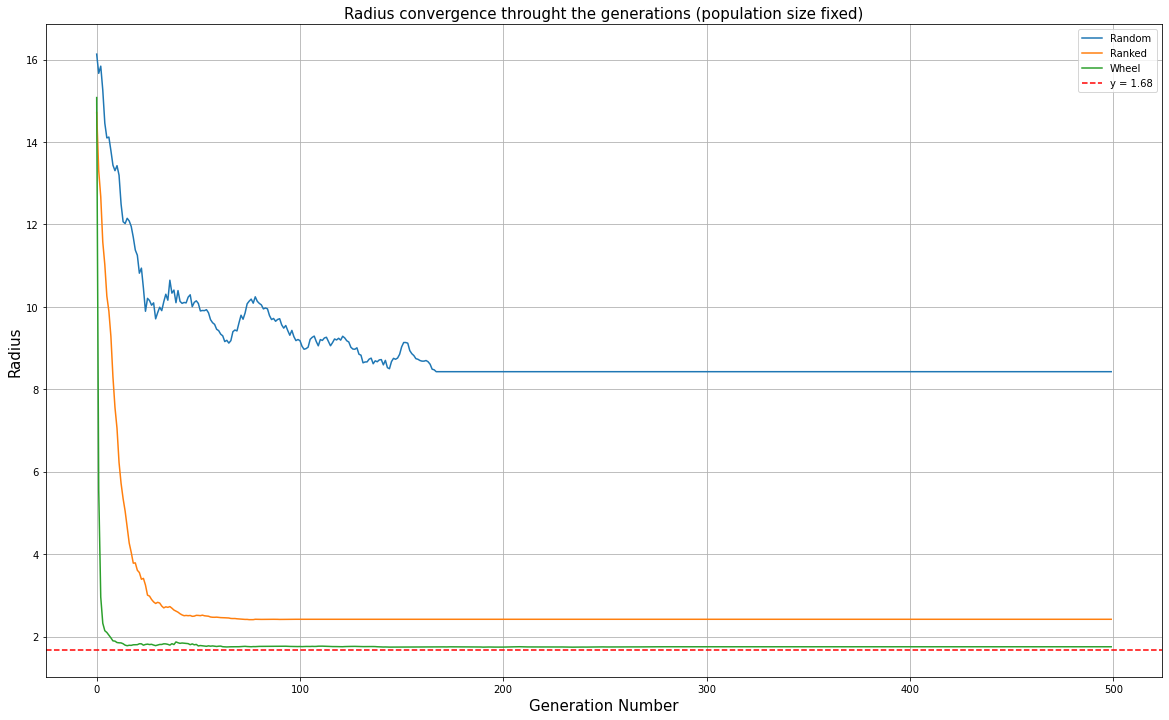

In [108]:
grouped = new_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'radius']
y2 = grouped.loc['Ranked Selection', 'radius']
y3 = grouped.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.show()

In [109]:
grouped.loc['Random Selection', 'radius']

generation
0      16.132941
1      15.666588
2      15.841176
3      15.260941
4      14.457176
         ...    
495     8.427059
496     8.427059
497     8.427059
498     8.427059
499     8.427059
Name: radius, Length: 500, dtype: float64

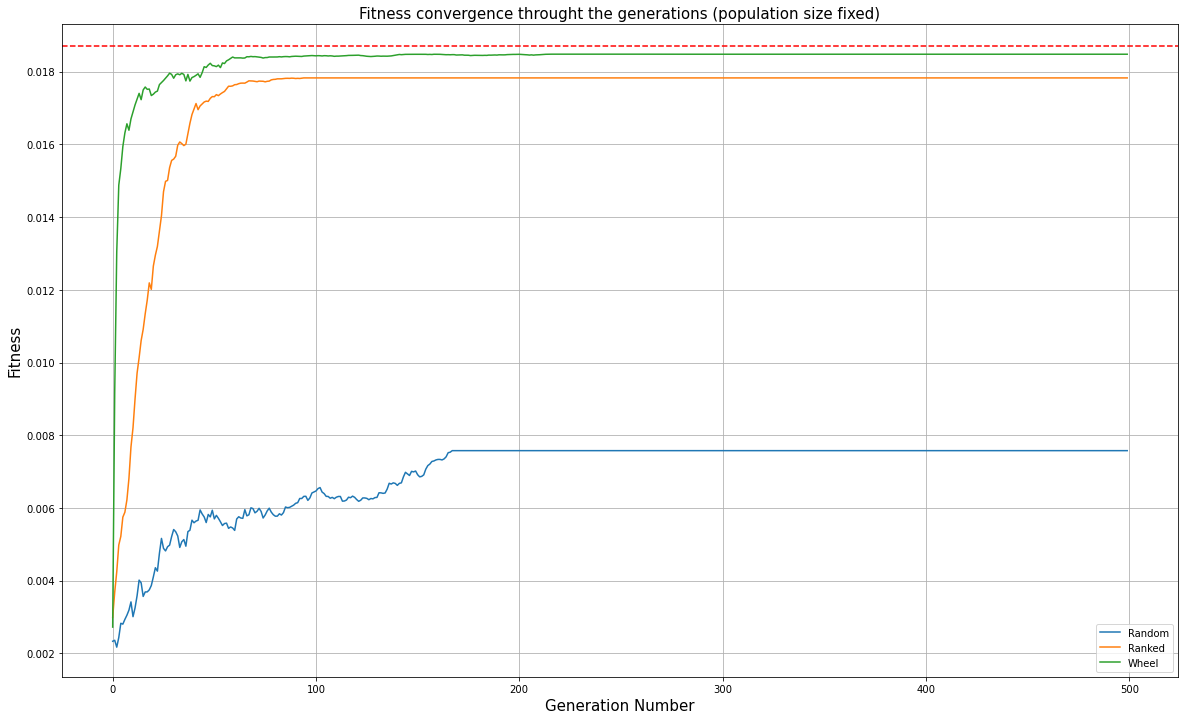

In [110]:
grouped = new_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'fitness']
y2 = grouped.loc['Ranked Selection', 'fitness']
y3 = grouped.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')

plt.show()

In [111]:
new_generations_df.groupby(by=['selection_type', 'pop_size']).describe(percentiles = [0.5])

radius                                            \
                             count       mean       std       min        50%   
selection_type   pop_size                                                      
Random Selection 5          2500.0  10.643059  0.536929  9.294118  10.588235   
                 15         7500.0  12.817522  1.079883  4.705882  12.705882   
                 25        12500.0   6.004998  1.294756  0.117647   5.882353   
                 35        17500.0   4.077271  2.086540  0.117647   3.764706   
                 45        22500.0   2.710264  3.342176  0.117647   1.882353   
                 55        27500.0   1.930481  3.098096  0.352941   1.058824   
                 65        32500.0  15.886671  2.706291  0.235294  15.294118   
                 75        37500.0  23.139893  3.788395  0.117647  24.470588   
                 85        42500.0   5.984974  4.116264  0.117647   4.117647   
                 95        47500.0   4.411980  2.100264  0.117647   3.882353   
Ranked Selection 5          2500.0   0.681600  1.917252  0.470588   0.470588   
                 15         7500.0  22.594839  0.959842  0.470588  22.588235   
                 25        12500.0   2.307304  2.607126  0.235294   1.882353   
                 35        17500.0   2.007503  1.514307  0.117647   1.882353   
                 45        22500.0   1.889846  1.808369  0.235294   1.647059   
                 55        27500.0   2.232920  1.326650  0.117647   2.117647   
                 65        32500.0   2.360822  2.574209  0.117647   1.882353   
                 75        37500.0   1.855664  1.778711  0.117647   1.647059   
                 85        42500.0   1.784933  1.407579  0.117647   1.647059   
                 95        47500.0   2.206269  2.037705  0.117647   1.882353   
Wheel Selection  5          2500.0   2.037412  0.689225  0.588235   2.000000   
                 15         7500.0   2.526086  0.751275  2.117647   2.470588   
                 25        12500.0   1.575473  0.775728  0.117647   1.529412   
                 35        17500.0   1.692578  0.777379  0.235294   1.647059   
                 45        22500.0   1.496099  0.768422  0.117647   1.411765   
                 55        27500.0   1.980051  0.893807  0.117647   1.882353   
                 65        32500.0   1.760503  0.818628  0.235294   1.764706   
                 75        37500.0   1.795975  0.788663  0.117647   1.764706   
                 85        42500.0   1.699870  0.805777  0.117647   1.647059   
                 95        47500.0   1.919415  0.746185  0.117647   1.882353   

                                     generation                          ...  \
                                 max      count   mean         std  min  ...   
selection_type   pop_size                                                ...   
Random Selection 5         26.823529     2500.0  249.5  144.366155  0.0  ...   
                 15        28.823529     7500.0  249.5  144.346902  0.0  ...   
                 25        30.000000    12500.0  249.5  144.343052  0.0  ...   
                 35        29.882353    17500.0  249.5  144.341403  0.0  ...   
                 45        30.000000    22500.0  249.5  144.340486  0.0  ...   
                 55        29.294118    27500.0  249.5  144.339903  0.0  ...   
                 65        30.000000    32500.0  249.5  144.339499  0.0  ...   
                 75        29.882353    37500.0  249.5  144.339203  0.0  ...   
                 85        30.000000    42500.0  249.5  144.338977  0.0  ...   
                 95        30.000000    47500.0  249.5  144.338798  0.0  ...   
Ranked Selection 5         29.529412     2500.0  249.5  144.366155  0.0  ...   
                 15        29.882353     7500.0  249.5  144.346902  0.0  ...   
                 25        29.411765    12500.0  249.5  144.343052  0.0  ...   
                 35        29.764706    17500.0  249.5  144.341403  0.0  ...   
                 45        

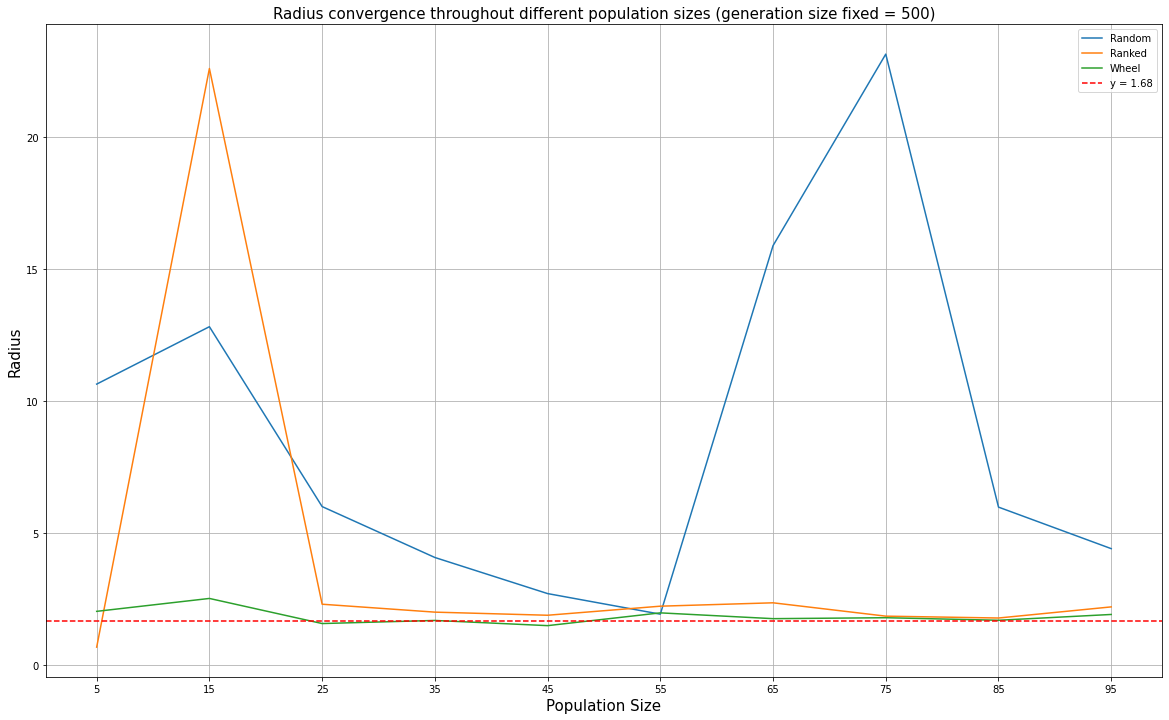

In [112]:
grouped_pop = new_generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'radius']))
y1 = grouped_pop.loc['Random Selection', 'radius']
y2 = grouped_pop.loc['Ranked Selection', 'radius']
y3 = grouped_pop.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  

plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.show()

In [113]:
grouped_pop.loc['Random Selection', 'radius'].values

array([10.64305882, 12.81752157,  6.00499765,  4.07727059,  2.71026405,
        1.93048128, 15.88667149, 23.13989333,  5.98497439,  4.41198019])

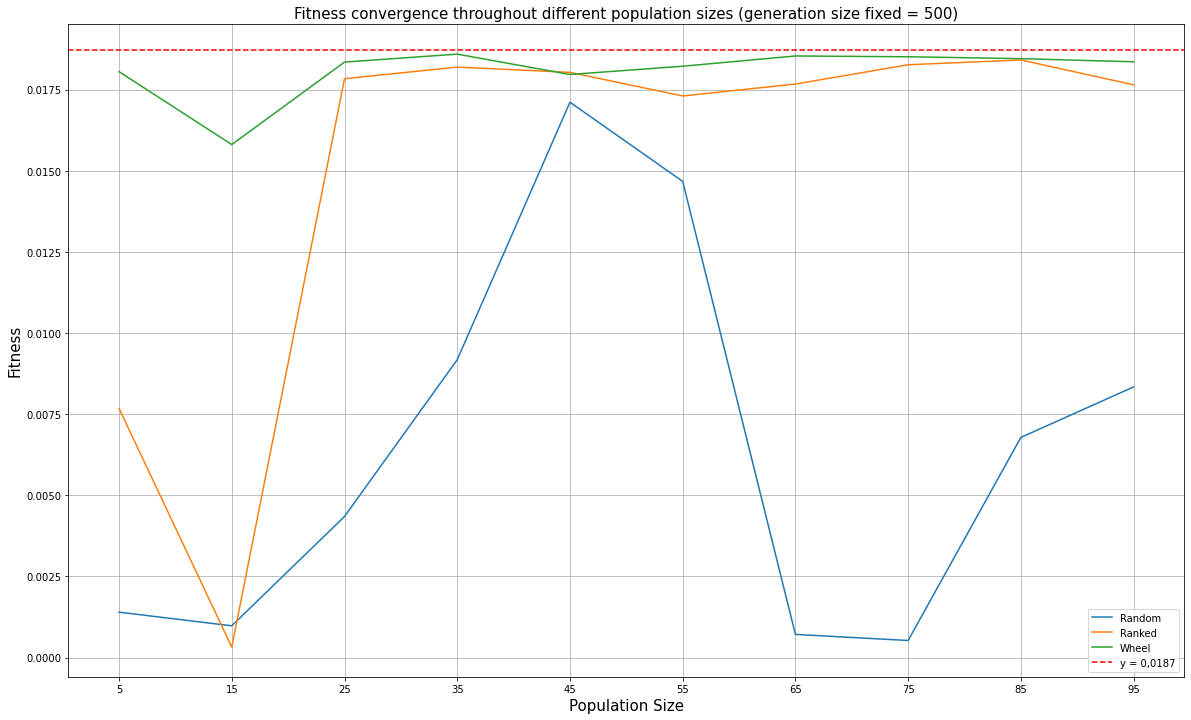

In [114]:
grouped_pop = new_generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'fitness']))
y1 = grouped_pop.loc['Random Selection', 'fitness']
y2 = grouped_pop.loc['Ranked Selection', 'fitness']
y3 = grouped_pop.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')
plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.legend()

plt.show()

WITH MUTATIONS

In [115]:
mutation_generations_df=generations_df[generations_df['mutation']!=0]
#checking the results
mutation_generations_df.sample(5)

,radius,generation,fitness,selection_type,pop_size,mutation
2754207,3.529412,113,0.010497,Wheel Selection,15,0.050
3310439,0.705882,454,0.011347,Ranked Selection,45,0.100
3248557,25.647059,484,0.000242,Random Selection,95,0.100
800181,4.352941,226,0.007528,Random Selection,45,0.001
3666665,2.823529,78,0.014017,Wheel Selection,85,0.100


In [116]:
#Sample Statistics
mutation_generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])

radius                                            \
                              count       mean       std       min        50%   
selection_type   generation                                                     
Random Selection 0           2000.0  15.155294  8.667799  0.117647  15.294118   
                 1           2000.0  14.875059  8.479945  0.117647  15.058824   
                 2           2000.0  14.851412  8.428627  0.117647  15.411765   
                 3           2000.0  14.420882  8.359738  0.117647  14.705882   
                 4           2000.0  14.079059  8.337260  0.117647  14.117647   
...                             ...        ...       ...       ...        ...   
Wheel Selection  495         2000.0   2.957471  3.649869  0.117647   1.882353   
                 496         2000.0   3.075588  3.809595  0.117647   1.882353   
                 497         2000.0   3.040824  3.664933  0.117647   1.882353   
                 498         2000.0   3.015353  3.626204  0.117647   1.882353   
                 499         2000.0   3.161353  3.808984  0.117647   1.882353   

                                       fitness                                \
                                   max   count      mean       std       min   
selection_type   generation                                                    
Random Selection 0           30.000000  2000.0  0.002829  0.004621  0.000177   
                 1           30.000000  2000.0  0.002867  0.004630  0.000177   
                 2           29.882353  2000.0  0.002836  0.004638  0.000178   
                 3           30.000000  2000.0  0.002945  0.004690  0.000177   
                 4           30.000000  2000.0  0.003173  0.004900  0.000177   
...                                ...     ...       ...       ...       ...   
Wheel Selection  495         28.588235  2000.0  0.015276  0.005507  0.000195   
                 496         28.000000  2000.0  0.015057  0.005652  0.000203   
                 497         29.411765  2000.0  0.015099  0.005664  0.000184   
                 498         25.764706  2000.0  0.015140  0.005632  0.000240   
                 499         25.764706  2000.0  0.014967  0.005800  0.000240   

                             ...   pop_size                  mutation  \
                             ...        std  min   50%   max    count   
selection_type   generation  ...                                        
Random Selection 0           ...  23.516516  5.0  75.0  95.0   2000.0   
                 1           ...  23.516516  5.0  75.0  95.0   2000.0   
                 2           ...  23.516516  5.0  75.0  95.0   2000.0   
                 3           ...  23.516516  5.0  75.0  95.0   2000.0   
                 4           ...  23.516516  5.0  75.0  95.0   2000.0   
...                          ...        ...  ...   ...   ...      ...   
Wheel Selection  495         ...  23.516516  5.0  75.0  95.0   2000.0   
                 496         ...  23.516516  5.0  75.0  95.0   2000.0   
                 497         ...  23.516516  5.0  75.0  95.0   2000.0   
                 498         ...  23.516516  5.0  75.0  95.0   2000.0   
                 499         ...  23.516516  5.0  75.0  95.0   2000.0   

                                                                  
                                mean       std    min   50%  max  
selection_type   generation                                       
Random Selection 0           0.04025  0.039127  0.001  0.03  0.1  
                 1           0.04025  0.039127  0.001  0.03  0.1  
                 2           0.04025  0.039127  0.001  0.03  0.1  
                 3           0.04025  0.039127  0.001  0.03  0.1  
                 4           0.04025  0.039127  0.001  0.03  0.1  
...                              ...       ...    ...   ...  ...  
Wheel Selection  495         0.04025  0.039127  0.001  0.03  0.1  
                 496         0.04025  0.039127  0.001  0.03  0.1  
             

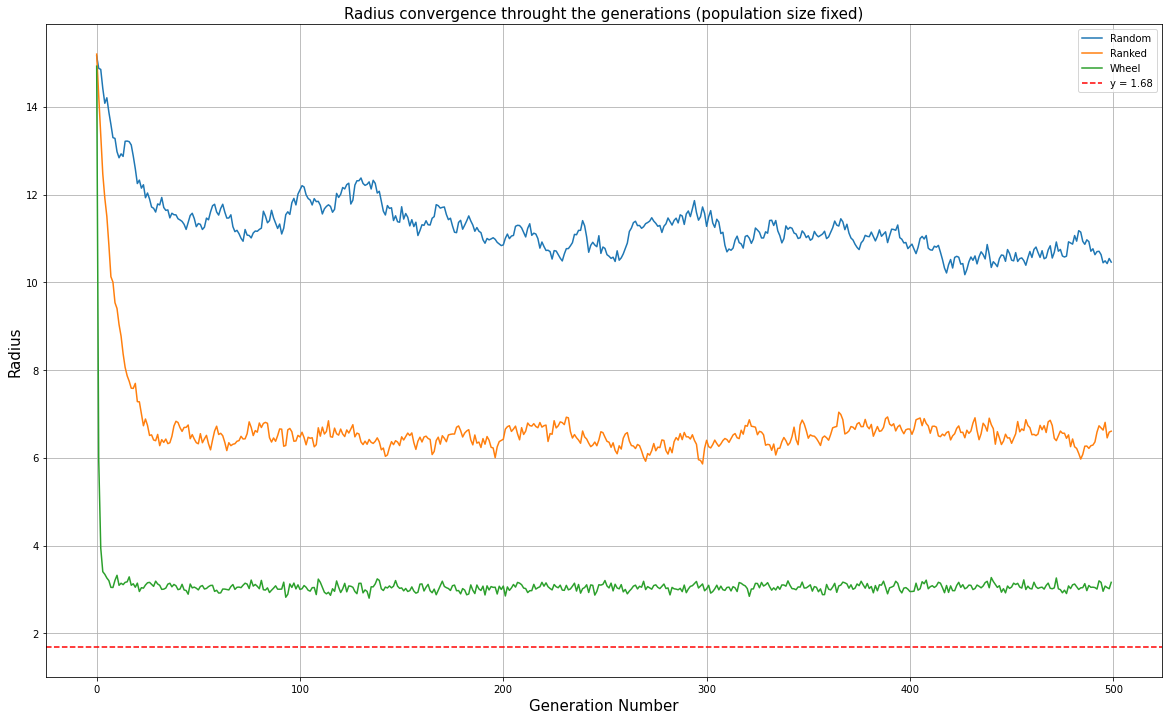

In [117]:
grouped = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'radius']
y2 = grouped.loc['Ranked Selection', 'radius']
y3 = grouped.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.show()

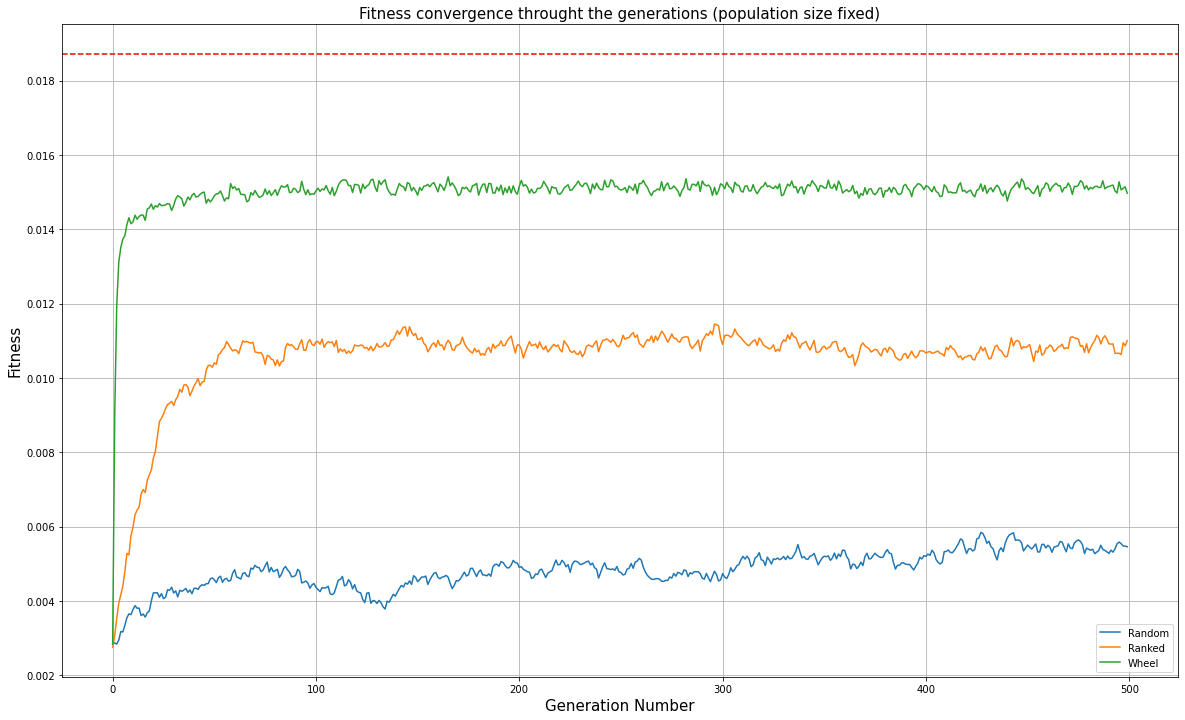

In [118]:
grouped = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'fitness']
y2 = grouped.loc['Ranked Selection', 'fitness']
y3 = grouped.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')

plt.show()

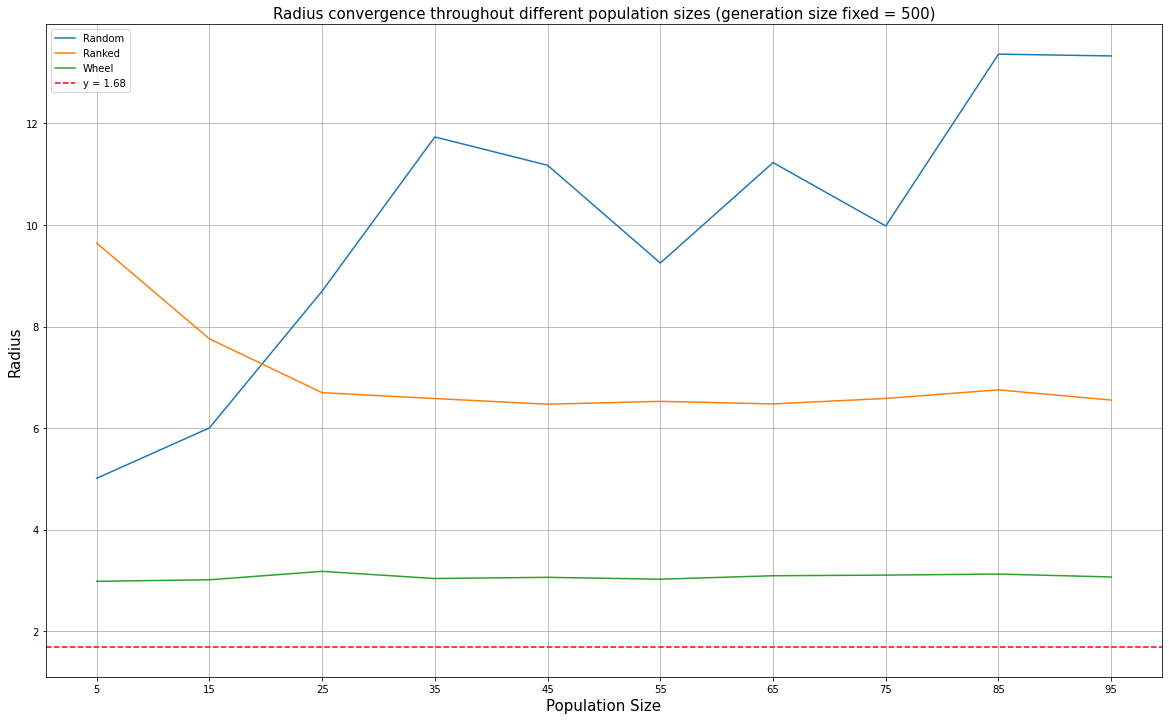

In [119]:
grouped_pop = mutation_generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'radius']))
y1 = grouped_pop.loc['Random Selection', 'radius']
y2 = grouped_pop.loc['Ranked Selection', 'radius']
y3 = grouped_pop.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  

plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.show()

In [219]:
#mutation_generations_df=generations_df[generations_df['mutation']!=0]
mutation_generations_df=generations_df
mutation_generations_df= mutation_generations_df[mutation_generations_df['selection_type']=='Ranked Selection']
mutation_generations_df= mutation_generations_df[mutation_generations_df['pop_size']== 55]
mutation_generations_df

,radius,generation,fitness,selection_type,pop_size,mutation
312500,1.882353,0,0.018471,Ranked Selection,55,0.0
312501,2.117647,0,0.017696,Ranked Selection,55,0.0
312502,2.117647,0,0.017696,Ranked Selection,55,0.0
312503,1.176471,0,0.016751,Ranked Selection,55,0.0
312504,2.588235,0,0.015320,Ranked Selection,55,0.0
...,...,...,...,...,...,...
3339995,23.764706,499,0.000282,Ranked Selection,55,0.1
3339996,24.470588,499,0.000266,Ranked Selection,55,0.1
3339997,24.588235,499,0.000263,Ranked Selection,55,0.1
3339998,26.705882,499,0.000223,Ranked Selection,55,0.1


In [220]:
grouped_pop = mutation_generations_df.groupby(by=['mutation','generation']).mean()
grouped_pop

radius   fitness  pop_size
mutation generation                               
0.0      0           13.180749  0.003479      55.0
         1           11.798930  0.003831      55.0
         2           10.346524  0.004680      55.0
         3            8.376471  0.005852      55.0
         4            6.759358  0.005610      55.0
...                        ...       ...       ...
0.1      495         12.622460  0.003440      55.0
         496         12.541176  0.004041      55.0
         497         11.734759  0.004008      55.0
         498         10.690909  0.004243      55.0
         499         10.697326  0.005164      55.0

[2500 rows x 3 columns]

In [221]:
fuck_you = np.array(list(grouped_pop['radius'].index)).transpose()
fuck_you[0]

array([0. , 0. , 0. , ..., 0.1, 0.1, 0.1])

In [222]:
list(fuck_you[0]).index(0.001)

500

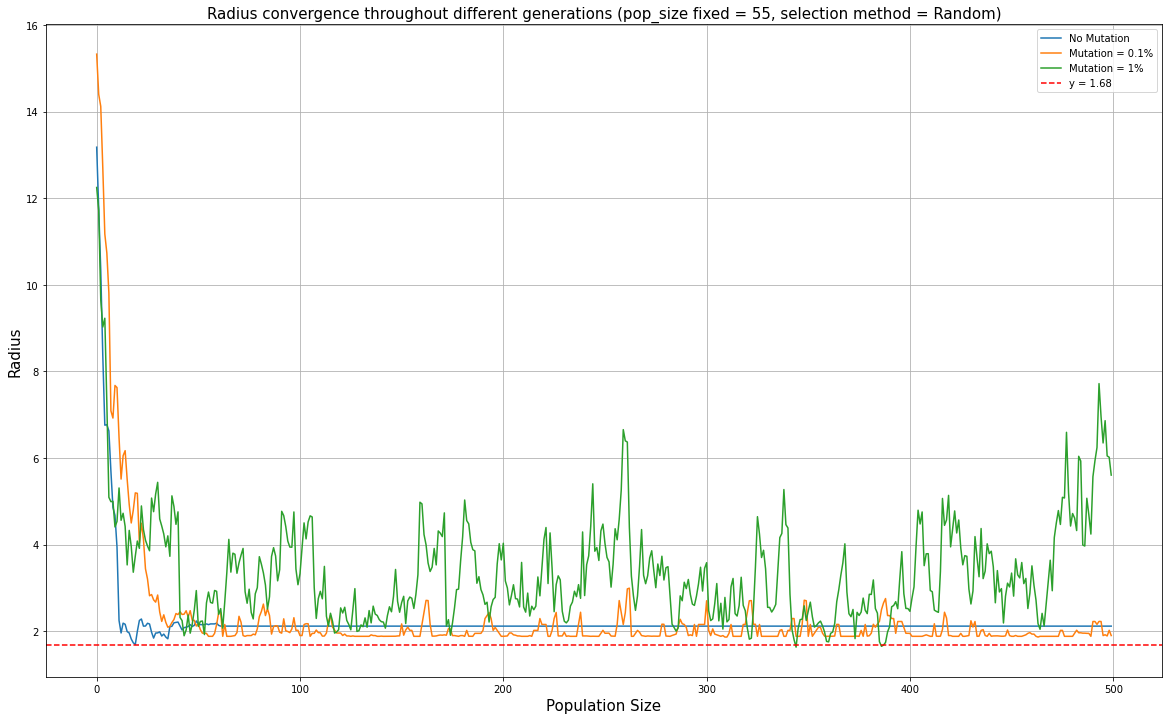

In [223]:
grouped_pop = mutation_generations_df.groupby(by=['mutation', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(500)
y1 = (grouped_pop['radius'].values)[:500]
y2 = (grouped_pop['radius'].values)[500:1000]
y3 = (grouped_pop['radius'].values)[1000:1500]
#y4 = (grouped_pop['radius'].values)[1500:2000]
#y5 = (grouped_pop['radius'].values)[2000:]

plt.title('Radius convergence throughout different generations (pop_size fixed = 55, selection method = Random)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1, label = 'No Mutation') 
plt.plot(x1,y2,label = 'Mutation = 0.1%')
plt.plot(x1,y3,label = 'Mutation = 1%') 
#plt.plot(x1,y4, label = 'Mutation = 5%')  
#plt.plot(x1,y5, label = 'Mutation = 10%')


plt.grid()
#plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
#plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.legend()

plt.show()

In [224]:
grouped_pop = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'radius']))
y1 = grouped_pop[grouped_pop['mutation'] == 0.001].loc['Random Selection', 'radius']
y2 = grouped_pop[grouped_pop['mutation'] == 0.01].loc['Random Selection', 'radius']
y3 = grouped_pop[grouped_pop['mutation'] == 0.1].loc['Random Selection', 'radius']
y4 = grouped_pop[grouped_pop['mutation'] == 0.05].loc['Random Selection', 'radius']

plt.title('Radius convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = '0.1%')
plt.plot(x1,y2,label = '1%') 
plt.plot(x1,y3, label = '10%') 
plt.plot(x1,y4, label = '5%')  

plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.show()

KeyError: 'Random Selection'